# Laplacian Score-regularized Concrete Autoencoders Demo

Let import some tools

In [1]:
import featselectlib
from pathlib import Path
from torch.utils import data
from scipy.stats import uniform
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import numpy as np
import torch
from torch.utils import data
import scipy

## Introduction

This Jupyter Notebook explores various unsupervised methods for feature selection, a crucial technique in machine learning and deep learning. Feature selection enhances model interpretability, speeds up training, and improves model performance by eliminating irrelevant or redundant data. 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


The default config could be found in src/config.yaml, but you can also pass these arguments as here:

In [3]:
def setup_model(input_dim, model_type='lscae',verbose=True,print_interval=100): 
    cfg = OmegaConf.create({
        "input_dim": input_dim,          # Dimension of input dataset (total #features)
        "k_selected": 2,            # Number of selected features
        "decoder_lr": 1e-3,         # Decoder learning rate
        "selector_lr": 1e-1,        # Concrete layer learning rate
        "min_lr": 1e-5,             # Minimal layer learning rate
        "weight_decay": 0,          # l2 weight penalty
        "batch_size": 64,           # Minibatch size
        "hidden_dim": 128,          # Hidden layers size
        "model": model_type, # lscae | cae | ls | gated_laplacian
        "scale_k": 2,               # Number of neighbors for computation of local scales for the kernel
        "laplacian_k": 50,          # Number of neighbors of each pooint, used for computation of the Laplacian
        "start_temp": 10,           # Initial temperature
        "min_temp": 1e-2,           # Final temperature
        "rec_lambda": .5,           # Balance between reconstruction and LS terms
        "num_epochs": 300,          # Number of training epochs
        "verbose": verbose,             # Whether to print to console during training
        "print_interval":print_interval
    })
    model = featselectlib.Lscae(input_dim=cfg.input_dim, kwargs=cfg)
    return model, cfg


## Visualize the Data

In this section, we will visualize the two moon dataset, which is a synthetic dataset commonly used for demonstrating clustering and classification algorithms. The dataset consists of two interleaving half circles (moons), making it a good example for testing the performance of various machine learning and deep learning methods on non-linearly separable data.

- **n**: The number of samples (data points) in the dataset. Increasing `n` will create more points in each moon, providing more data for training and evaluation.
- **p**: The number of features (dimensions) for each sample. In the two moon dataset, while each sample has two informative dimensions representing the (x, y) coordinates in a two-dimensional space, there are also additional nuisance dimensions. These nuisance dimensions are irrelevant to the underlying structure of the data and serve to challenge the feature selection and classification algorithms.

To make this problem linearly separable, we increased the distance between the moons. This adjustment helps in evaluating the performance of feature selection methods and classification algorithms under different levels of complexity.

Below, we visualize the two moon dataset to get an understanding of its structure and the distribution of data points.


In [4]:

def create_twomoon_dataset(n=1200, d=10, noise=0.1):
    """
    Creates two moon clusters in 2D, adding p nuisance features and d noisy copies of one of the original features
    n: size of data (int)
    d: number of nuisance dimensions (int), and number of redundant copies
    noise: noise level (double)
    """
    relevant, y = make_moons(n_samples=n, shuffle=False, noise=noise, random_state=None)
    nuisance = uniform.rvs(size=[n, d])
    data = np.concatenate([relevant, nuisance], axis=1)
    scaler = StandardScaler()
    data = scaler.fit_transform(data)
    
    # plt.scatter(data[:, 0], data[:, 1])
    # plt.show()

    f,ax = plt.subplots(1,2,figsize=(10,5))
        

    ax[0].scatter(x=data[:,0], y=data[:,1], s=150, c=y.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
    ax[0].set_xlabel('$x_1$',fontsize=20)
    ax[0].set_ylabel('$x_2$',fontsize=20)
    ax[0].set_title('Target y')
    ax[1].scatter(x=data[:,2], y=data[:,3], s=150, c=y.reshape(-1),alpha=0.4,cmap=plt.cm.get_cmap('RdYlBu'),)
    ax[1].set_xlabel('$x_3$',fontsize=20)
    ax[1].set_ylabel('$x_4$',fontsize=20)
    ax[1].set_title('Target y')
    plt.tick_params(labelsize=10)

    return data

1200

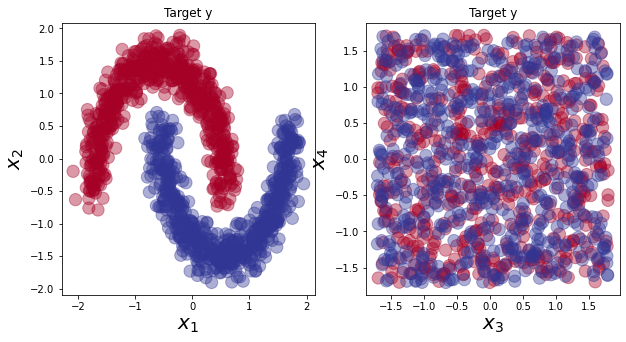

In [5]:
X = create_twomoon_dataset(1200,15)
Xn=scipy.stats.zscore(X, axis=0)
dataset = data.TensorDataset(torch.Tensor(Xn))
loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
input_dim = Xn.shape[1]
X.shape[0]


# Testing the Models

The methods we will focus on are:

1. LS-CAE 
2. CAE 
3. LS 
4. Gated Laplacian

For each of these methods, we provide code to run simple feature selection, and we also conducted experiments to calculate the accuracy of feature selection over different nuisance dimensions.



In [10]:
model_gl=featselectlib.GatedLaplacianModel(input_dim=X.shape[1], seed=1, lam=0.1, fac=2, knn=5,
                                is_param_free_loss=True, num_epochs=2500, batch_size=64,
                                learning_rate=0.01,verbose=True,print_interval=500)
selected_features = model_gl.select_features(loader)
print(selected_features)

Epoch 1/2500, Loss: -0.0190, Laplacian Score: -0.0160 reg: 0.839485228061676
Selection probs: 
  [0.48503143 0.4884391  0.5068242  0.5016491  0.50827277 0.50234497
 0.4934366  0.50809383 0.5039932  0.49795175 0.47759217 0.48564017
 0.50049436 0.49361768 0.49182728 0.49886793 0.4919345 ] 

Epoch 501/2500, Loss: -0.0208, Laplacian Score: -0.0162 reg: 0.7789477109909058
Epoch 1001/2500, Loss: -0.0408, Laplacian Score: -0.0246 reg: 0.6030513048171997
Selection probs: 
  [0.38028038 0.48741275 0.08911109 0.08653742 0.11237115 0.09854198
 0.07549518 0.10138151 0.14644125 0.07385397 0.07246107 0.05003718
 0.08797213 0.09474275 0.10697064 0.14537069 0.09707248] 

Epoch 1501/2500, Loss: -0.9077, Laplacian Score: -0.1079 reg: 0.11887583136558533
Epoch 2001/2500, Loss: -0.9228, Laplacian Score: -0.1089 reg: 0.11795982718467712
Selection probs: 
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

{0, 1}


In [11]:
step=3
max_nuisance=15
accuracies_gl = featselectlib.correct_feats_selection(trials=10, max_nuisance=15, step=3, selected_model='gated_laplacain',verbose=False)

Running experiments on: cpu


<Figure size 432x288 with 0 Axes>

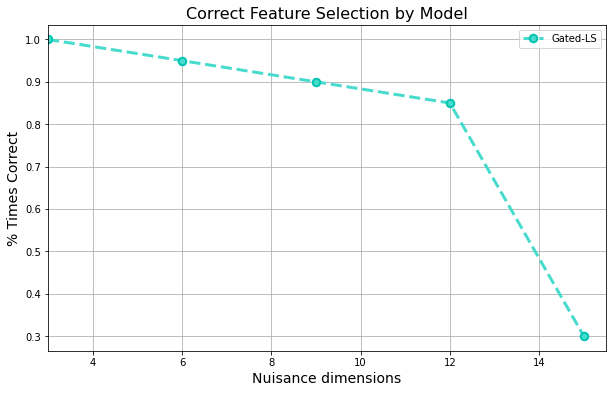

In [12]:
plt.clf()
plt.figure(figsize=(10, 6))

plt.plot(
    list(range(step, max_nuisance + 1, step)),
    accuracies_gl,
    "--o",
    color="#47DBCD",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#03C3B1",
    markersize=7.5,
    label="Gated-LS",
)

plt.xlabel("Nuisance dimensions",fontsize=14)
plt.ylabel("% Times Correct",fontsize=14)
plt.title("Correct Feature Selection by Model",fontsize=16)
plt.legend()
plt.gca()
plt.xlim(step,max_nuisance+0.5)
plt.grid(True)
plt.show()

In [13]:
lscae_model, lscae_cfg = setup_model(X.shape[1], 'lscae',verbose=True,print_interval=50)
selected_features_lscae,num_of_selected,epoch_recon_loss,epoch_ls_loss = lscae_model.select_features(loader)

Epoch 1\300, loss: 0.000, ls loss: -0.00043, recon loss: 0.980
Selection probs: 
  [0.05880143 0.06302315 0.06638063 0.06383756 0.06255405 0.06513774
 0.0597754  0.06765673 0.0647577  0.05721347 0.06662141 0.06827129
 0.06860334 0.06552065 0.05802306 0.06808908 0.06308671] 

Epoch 51\300, loss: 0.000, ls loss: -0.91361, recon loss: 0.886
Epoch 101\300, loss: 0.000, ls loss: -0.89762, recon loss: 0.876
Selection probs: 
  [1.0000000e+00 1.0000000e+00 1.1895342e-40 1.4299872e-39 1.1363550e-40
 8.8281803e-44 8.6249920e-42 2.9329177e-42 1.5513775e-41 5.2833156e-41
 1.1490647e-42 1.0162251e-36 2.3450730e-41 1.0935733e-41 5.0026355e-43
 1.1488826e-40 5.1108146e-38] 

Epoch 151\300, loss: 0.000, ls loss: -0.90392, recon loss: 0.875
Epoch 201\300, loss: 0.000, ls loss: -0.91164, recon loss: 0.870
Selection probs: 
  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

Epoch 251\300, loss: 0.000, ls loss: -0.89517, recon loss: 0.875
LS-CAE learning rate = 0.0000100
LS-CAE learning rate = 0.00

In [ ]:
accuracies_lscae = featselectlib.correct_feats_selection(trials=10, max_nuisance=max_nuisance, step=step, selected_model='lscae',verbose=False)

<Figure size 432x288 with 0 Axes>

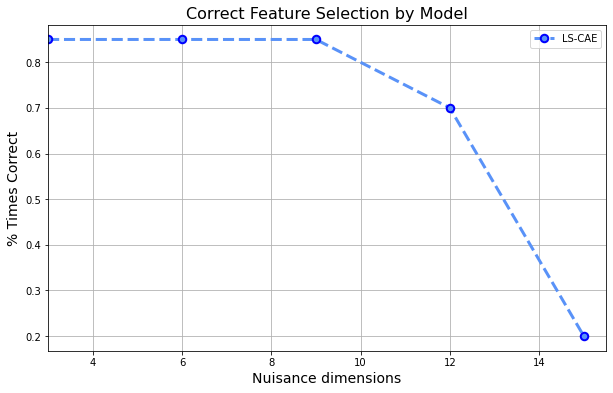

In [15]:
plt.clf()
plt.figure(figsize=(10, 6))

plt.plot(
    list(range(step, max_nuisance + 1, step)),
    accuracies_lscae,
    "--o",
    color="#5992F8",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="b",
    markersize=7.5,
    label="LS-CAE",
)

plt.xlabel("Nuisance dimensions",fontsize=14)
plt.ylabel("% Times Correct",fontsize=14)
plt.title("Correct Feature Selection by Model",fontsize=16)
plt.legend()
plt.gca()
plt.xlim(step,max_nuisance+0.5)
plt.grid(True)
plt.show()

In [25]:
cae_model, cae_cfg = setup_model(X.shape[1], 'cae',verbose=True,print_interval=50)
selected_features_cae = cae_model.select_features(loader)

Epoch 1\300, loss: 0.974, ls loss: -0.00042, recon loss: 0.974
Selection probs: 
  [0.0709476  0.06967983 0.06583574 0.0612021  0.06074508 0.06153431
 0.06542182 0.06375474 0.06356372 0.07048848 0.06685735 0.06127711
 0.06046215 0.06194681 0.06056385 0.06667478 0.05876088] 

Epoch 51\300, loss: 0.856, ls loss: -0.00366, recon loss: 0.856
Epoch 101\300, loss: 0.877, ls loss: -0.46865, recon loss: 0.877
Selection probs: 
  [2.0977294e-02 4.2621039e-02 6.9584125e-06 7.1851064e-05 1.1874172e-05
 6.6140888e-07 4.4852120e-05 3.2353279e-07 1.4399230e-10 3.0809360e-09
 1.7023189e-06 9.5826745e-06 1.1467951e-05 8.7114990e-05 2.2249449e-05
 6.0518955e-06 9.7884309e-01] 

Epoch 151\300, loss: 0.872, ls loss: -0.80475, recon loss: 0.872
Epoch 201\300, loss: 0.870, ls loss: -0.84168, recon loss: 0.870
Selection probs: 
  [3.0578082e-23 1.0000000e+00 0.0000000e+00 1.4012985e-45 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000

In [ ]:
accuracies_cae = featselectlib.correct_feats_selection(trials=10, max_nuisance=15, step=3, selected_model='cae',verbose=False)


<Figure size 432x288 with 0 Axes>

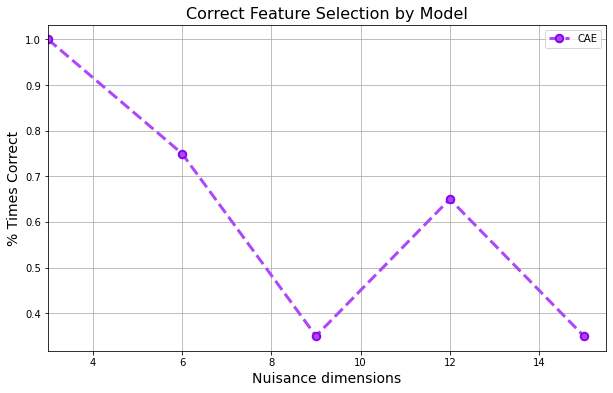

In [18]:
plt.clf()
plt.figure(figsize=(10, 6))

plt.plot(
    list(range(step, max_nuisance + 1, step)),
    accuracies_cae,
    "--o",
    color="#AE46FA",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#8906E9",
    markersize=7.5,
    label="CAE",
)

plt.xlabel("Nuisance dimensions",fontsize=14)
plt.ylabel("% Times Correct",fontsize=14)
plt.title("Correct Feature Selection by Model",fontsize=16)
plt.legend()
plt.xlim(step,max_nuisance+0.5)
plt.gca()
plt.grid(True)
plt.show()

In [19]:
ls_model, ls_cfg = setup_model(X.shape[1], 'ls',verbose=True,print_interval=50)
selected_features_lscae = ls_model.select_features(loader)

Epoch 1\300, loss: -0.000, ls loss: -0.00049, recon loss: 1.175
Selection probs: 
  [0.0605257  0.06029342 0.06033089 0.06067108 0.063259   0.06464161
 0.06227244 0.06384378 0.05875226 0.06402644 0.06244655 0.062126
 0.05688466 0.06343271 0.06087187 0.06230178 0.06181644] 

Epoch 51\300, loss: -0.825, ls loss: -0.82459, recon loss: 1.227
Epoch 101\300, loss: -0.815, ls loss: -0.81457, recon loss: 1.231
Selection probs: 
  [1.00e+00 2.80e-44 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 1.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 6.08e-43] 

Epoch 151\300, loss: -0.814, ls loss: -0.81448, recon loss: 1.227
Epoch 201\300, loss: -0.824, ls loss: -0.82363, recon loss: 1.231
Selection probs: 
  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.] 

Epoch 251\300, loss: -0.817, ls loss: -0.81688, recon loss: 1.229
LS-CAE learning rate = 0.0000100
LS-CAE learning rate = 0.0000100
Finished training LS-CAE
Selected features: {0, 9}


In [ ]:
accuracies_ls = featselectlib.correct_feats_selection(trials=10, max_nuisance=15, step=3, selected_model='ls',verbose=False)

<Figure size 432x288 with 0 Axes>

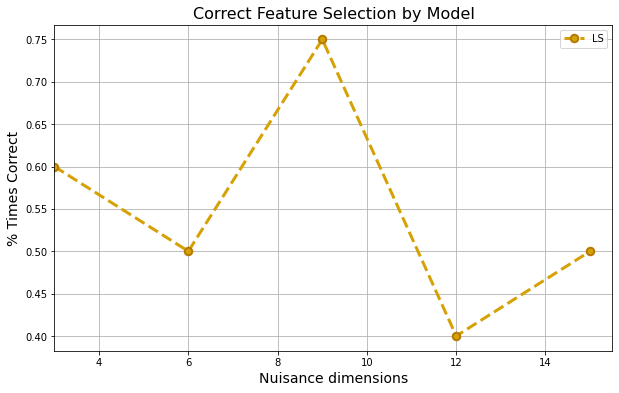

In [21]:
plt.clf()
plt.figure(figsize=(10, 6))

plt.plot(
    list(range(step, max_nuisance + 1, step)),
    accuracies_ls,
    "--o",
    color="#D6A104",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#B47A04",
    markersize=7.5,
    label="LS",
)

plt.xlabel("Nuisance dimensions",fontsize=14)
plt.ylabel("% Times Correct",fontsize=14)
plt.title("Correct Feature Selection by Model",fontsize=16)
plt.legend()
plt.gca()
plt.xlim(step,max_nuisance+0.5)
plt.grid(True)
plt.show()

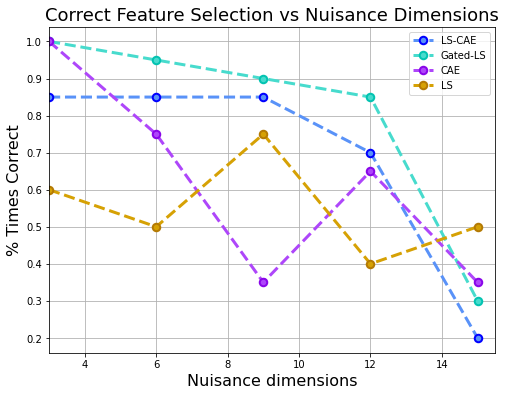

In [24]:
# Test and plot results for all models
# accuracies_all = correct_feats_selection(trials=5, max_nuisance=15, step=3, selected_model='All')
nuisance_dimensions = np.arange(
    3, 16, 3
)  # Adjust the range and step according to your data
plt.figure(figsize=(8, 6))
plt.plot(
    nuisance_dimensions,
    accuracies_lscae,
    "--o",
    color="#5992F8",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="b",
    markersize=7.5,
    label="LS-CAE",
)
plt.plot(
    nuisance_dimensions,
    accuracies_gl,
    "--o",
    color="#47DBCD",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#03C3B1",
    markersize=7.5,
    label="Gated-LS",
)
plt.plot(
    nuisance_dimensions,
    accuracies_cae,
    "--o",
    color="#AE46FA",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#8906E9",
    markersize=7.5,
    label="CAE",
)
plt.plot(
    nuisance_dimensions,
    accuracies_ls,
    "--o",
    color="#D6A104",
    linewidth=3,
    markeredgewidth=2,
    markeredgecolor="#B47A04",
    markersize=7.5,
    label="LS",
)

plt.xlabel("Nuisance dimensions",fontsize=16)
plt.ylabel("% Times Correct",fontsize=16)
plt.title("Correct Feature Selection vs Nuisance Dimensions",fontsize=18)
plt.legend()
plt.gca()
plt.xlim(step,max_nuisance+0.5)
plt.grid(True)
plt.show()